In [1]:
import requests
import json
from collections import namedtuple
from collections import defaultdict
from Bio.Data import IUPACData
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
def construct_query(params):
    query = {
        "query": {
            "type": params.get("type", "terminal"),
            "service": params.get("service", "full_text"),
            "parameters": {
                "value": params.get("value", '"4HHB"')
            }
        },
        "request_options": {
            "paginate": {
                "start": params.get("start", 0),
                "rows": params.get("rows", 10)
            }
        },

        "return_type": params.get("return_type", "entry")
    }
    query = json.dumps(query)
    return query

def fetch_data(query):
    data = requests.get(f'https://search.rcsb.org/rcsbsearch/v2/query?json={query}')
    results = data.json()
    #print(json.dumps(results, indent=4))
    return results

value = '"PF00873"'
params = {"type": "terminal", "service": "full_text", "value": value, "start": 0, "rows": 999,
        "return_type": "entry"}
query = construct_query(params)
results = fetch_data(query)

In [3]:
def process_search_result(results):
    molecules = []
    for dicts in results['result_set']:
        molecules.append(dicts['identifier'])
    return molecules

molecules = process_search_result(results)

In [4]:
def collect_ligand_information(entries):
    base_url = 'https://data.rcsb.org/rest/v1/core/entry/'

    StructureHit = namedtuple('StructureHit', ['entry', 'method', 'nonpolymer_entity_id', 'nonpolymer_comp', 'title'])
    collection = []

    for entry in entries:
        query_url = base_url+entry
        response = requests.get(query_url, stream=True)
        response_json = response.json()
        #print(response_json)
        method = response_json.get('exptl', 'No experimental information found')
        nonpolymer_entity_id = response_json.get('rcsb_entry_container_identifiers', 
                                                 'RCSB entry container id not found').get('non_polymer_entity_ids', 
                                                                                          'No non-polymers found')
        nonpolymer_comp = response_json.get('rcsb_entry_info', 
                                            'RCSB entry info not found').get('nonpolymer_bound_components', 
                                                                             'No bound ligands found')
        title = response_json.get('struct', 'Struct key not found').get('title', 'No entry title')
        collection.append(StructureHit(entry, method, nonpolymer_entity_id, nonpolymer_comp, title))
    return collection

collection_ligands = collect_ligand_information(molecules)

In [ ]:
def collect_nonpolymer_entity_information(entryid, entities):
    base_url = 'https://data.rcsb.org/rest/v1/core/nonpolymer_entity/'

    NonPolymerHit = namedtuple('NonPolymerHit', ['comp_id', 'name'])
    collection = []

    for entity in entities:
        query_url = base_url+entryid+'/'+entity
        response = requests.get(query_url, stream=True)
        response_json = response.json()
        #print(json.dumps(response_json, indent=4))
        comp_id = response_json.get('pdbx_entity_nonpoly', 
                                        'PDBx entity nonpoly not found').get('comp_id', 
                                                                             'No comp_id defined')
        name = response_json.get('pdbx_entity_nonpoly', 
                                        'PDBx entity nonpoly not found').get('name', 
                                                                             'No name defined')
        collection.append(NonPolymerHit(comp_id, name))
    return collection

def crossref_cleanup_nonpolymer_entities(nonpolymer_collection):
    all_entities = []
    # Initialize two-level defaultdict with specified keys at second level
    entity_dict = defaultdict(lambda: {"name": "", "entry": [], "title": [], "smiles": ""})
    for hit in nonpolymer_collection:
        if isinstance(hit.nonpolymer_entity_id, list):
            #print(hit.title, '\n', hit.nonpolymer_entity_id)
            collection = collect_nonpolymer_entity_information(hit.entry, hit.nonpolymer_entity_id)
            for molecule in collection:
                #rint(molecule.comp_id)
                entity_dict[molecule.comp_id]["entry"].append(hit.entry)
                entity_dict[molecule.comp_id]["title"].append(hit.title)
                all_entities.append(molecule.comp_id)
    # Convert to unique entries only
    all_entities.sort()
    unique_entities = sorted(list(set(all_entities)))

    return unique_entities, entity_dict

unique_entities, entity_dict = crossref_cleanup_nonpolymer_entities(collection_ligands)

Multi-drug efflux pump RE-CmeB bound with ampicillin 
 ['2']
ZZ7
Crystal structure of the multidrug efflux transporter BpeB from Burkholderia pseudomallei 
 ['2', '3']
UMQ
PG4
Crystal Structure of the Multidrug effulx transporter BpeF from Burkholderia pseudomallei. 
 ['2']
LMT
Multi-drug efflux pump RE-CmeB bound with Erythromycin 
 ['2']
ERY
Multi-drug efflux pump RE-CmeB bound with Chloramphenicol 
 ['2']
CLM
Single particle cryo-EM co-structure of Klebsiella pneumoniae AcrB with the BDM91288 efflux pump inhibitor at 2.97 Angstrom resolution 
 ['2', '3', '4']
WQW
WR6
PG8
Low resolution crystal structure of the bacterial multidrug efflux transporter AcrB in the presence of cadmium 
 ['2']
CD
multi-drug efflux pump RE-CmeB bound with Ciprofloxacin 
 ['2']
CPF
Erythromycin bound Klebsiella pneumoniae AcrB multidrug efflux pump 
 ['2']
ERY
X-ray crystal structure of a heavy metal efflux pump, crystal form II 
 ['2']
ZN
Cryo-EM structure of an Acinetobacter baumannii multidrug efflux pum

In [6]:
def collect_chemical_information(molecules):
    base_url = 'https://data.rcsb.org/rest/v1/core/chemcomp/'
    three_letter_code = [tlc.upper() for tlc in IUPACData.protein_letters_3to1]
    three_letter_code.append('MSE')

    MoleculeHit = namedtuple('MoleculeHit', ['molecule', 'name', 'smiles'])
    collection = []

    for molecule in molecules:
        if molecule in three_letter_code:
            continue
        query_url = base_url+molecule
        response = requests.get(query_url, stream=True)
        response_json = response.json()
        name = response_json['chem_comp']['name']
        can_smiles = ''
        for descriptor in response_json['pdbx_chem_comp_descriptor']:
            if descriptor['type'] == 'SMILES_CANONICAL':
                can_smiles = descriptor['descriptor']
                break
        collection.append(MoleculeHit(molecule, name, can_smiles))
    return collection

collection_chemicals = collect_chemical_information(unique_entities)

In [ ]:
for chemical in collection_chemicals:
    entity_dict[chemical.molecule]["name"] = chemical.name
    entity_dict[chemical.molecule]["smiles"] = chemical.smiles
#print(entity_dict)
print(unique_entities)

defaultdict(<function crossref_cleanup_nonpolymer_entities.<locals>.<lambda> at 0x7ff850a9ad40>, {'ZZ7': {'name': '(2R,4S)-2-[(R)-{[(2R)-2-amino-2-phenylacetyl]amino}(carboxy)methyl]-5,5-dimethyl-1,3-thiazolidine-4-carboxylic acid', 'entry': ['8GJK'], 'title': ['Multi-drug efflux pump RE-CmeB bound with ampicillin'], 'smiles': 'CC1(C)S[C@@H](N[C@H]1C(O)=O)[C@H](NC(=O)[C@H](N)c2ccccc2)C(O)=O'}, 'UMQ': {'name': 'UNDECYL-MALTOSIDE', 'entry': ['7WLS'], 'title': ['Crystal structure of the multidrug efflux transporter BpeB from Burkholderia pseudomallei'], 'smiles': 'CCCCCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@H]1O'}, 'PG4': {'name': 'TETRAETHYLENE GLYCOL', 'entry': ['7WLS', '6ZOC', '6ZO6'], 'title': ['Crystal structure of the multidrug efflux transporter BpeB from Burkholderia pseudomallei', 'Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV binding to the access pocket of AcrB-G616P T protomer', 'Minocyc

Comp Name: ZZ7
Full Name: (2R,4S)-2-[(R)-{[(2R)-2-amino-2-phenylacetyl]amino}(carboxy)methyl]-5,5-dimethyl-1,3-thiazolidine-4-carboxylic acid.
8GJK
Multi-drug efflux pump RE-CmeB bound with ampicillin


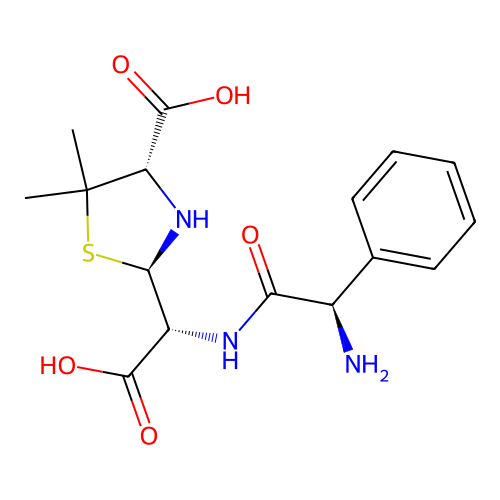

Comp Name: UMQ
Full Name: UNDECYL-MALTOSIDE.
7WLS
Crystal structure of the multidrug efflux transporter BpeB from Burkholderia pseudomallei


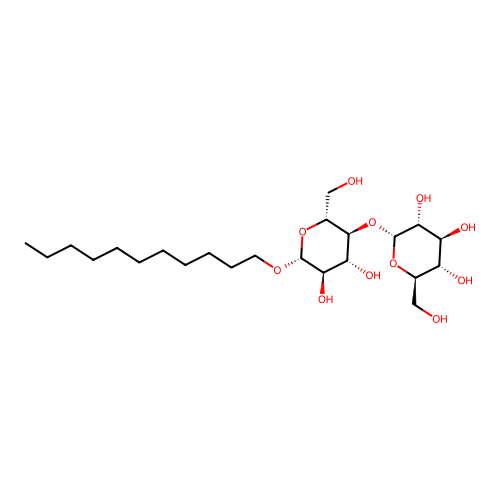

Comp Name: PG4
Full Name: TETRAETHYLENE GLYCOL.
7WLS
Crystal structure of the multidrug efflux transporter BpeB from Burkholderia pseudomallei
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV binding to the access pocket of AcrB-G616P T protomer
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


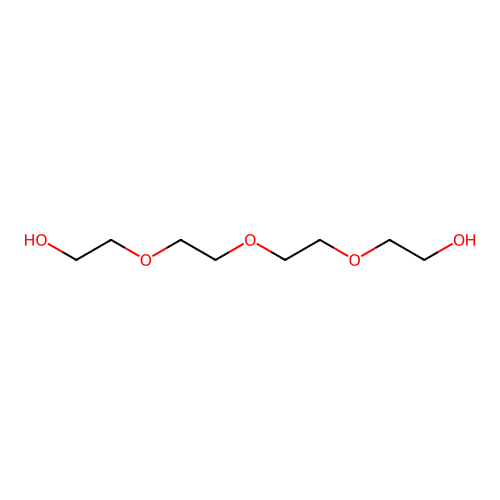

Comp Name: LMT
Full Name: DODECYL-BETA-D-MALTOSIDE.
7WLV
Crystal Structure of the Multidrug effulx transporter BpeF from Burkholderia pseudomallei.
6ZOE
AcrB-F563A symmetric T protomer
7CZ9
Crystal structure of multidrug efflux transporter OqxB from Klebsiella pneumoniae
2V50
The Missing Part of the Bacterial MexAB-OprM System: Structural determination of the Multidrug Exporter MexB
3W9I
Structural basis for the inhibition of bacterial multidrug exporters
2J8S
Drug Export Pathway of Multidrug Exporter AcrB Revealed by DARPin Inhibitors
3W9J
Structural basis for the inhibition of bacterial multidrug exporters
4C48
Crystal structure of AcrB-AcrZ complex
4DX6
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
4U96
Coupling of remote alternating-access transport mechanisms for protons and substrates in the multidrug efflux pump AcrB
4U8V
Coupling of remote alternating-access transport mechanisms for protons 

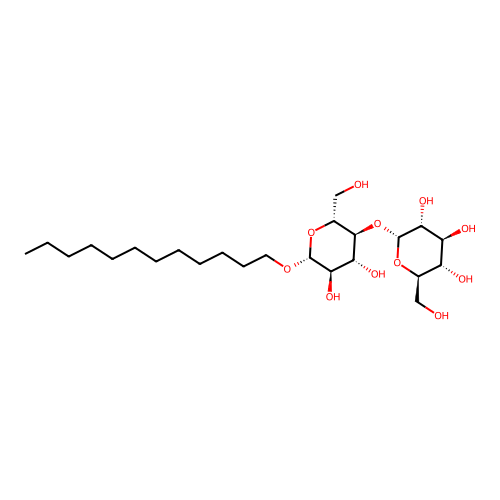

Comp Name: ERY
Full Name: ERYTHROMYCIN A.
8GK0
Multi-drug efflux pump RE-CmeB bound with Erythromycin
8FFS
Erythromycin bound Klebsiella pneumoniae AcrB multidrug efflux pump
6VKT
Cryo-electron microscopy structures of a gonococcal multidrug efflux pump illuminate a mechanism of erythromycin drug recognition
3AOC
Structures of the multidrug exporter AcrB reveal a proximal multisite drug-binding pocket
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV binding to the access pocket of AcrB-G616P T protomer


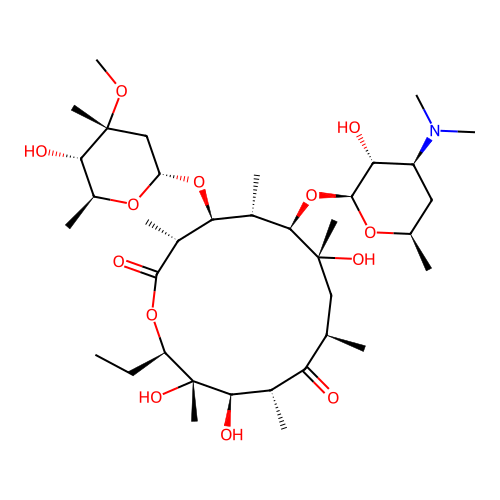

Comp Name: CLM
Full Name: CHLORAMPHENICOL.
8GK4
Multi-drug efflux pump RE-CmeB bound with Chloramphenicol


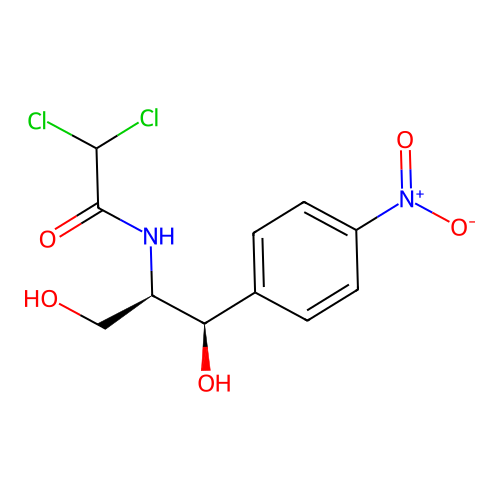

Comp Name: WQW
Full Name: 3-chloranyl-2,6-di(piperazin-4-ium-1-yl)quinoline.
8P1I
Single particle cryo-EM co-structure of Klebsiella pneumoniae AcrB with the BDM91288 efflux pump inhibitor at 2.97 Angstrom resolution


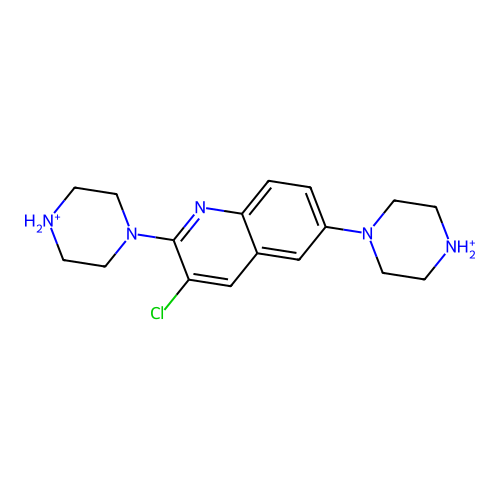

Comp Name: WR6
Full Name: [(2~{R})-1-[[(2~{R})-2,3-bis(oxidanyl)propoxy]-oxidanyl-phosphoryl]oxy-3-undecanoyloxy-propan-2-yl] tricosanoate.
8P1I
Single particle cryo-EM co-structure of Klebsiella pneumoniae AcrB with the BDM91288 efflux pump inhibitor at 2.97 Angstrom resolution
8QZQ
Single particle cryo-EM co-structure of E. coli AcrB with bound BDM91531 inhibitor


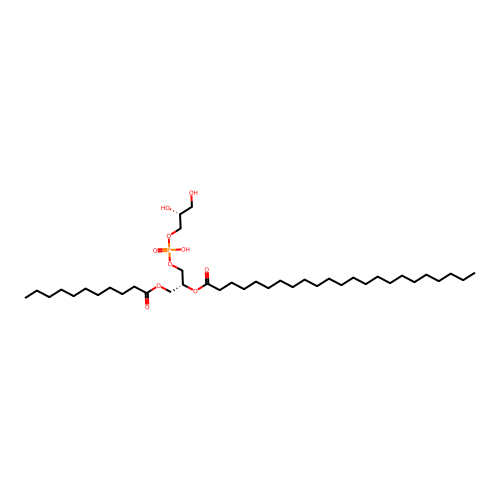

Comp Name: PG8
Full Name: 1,2-DIOCTANOYL-SN-GLYCERO-3-[PHOSPHO-RAC-(1-GLYCEROL).
8P1I
Single particle cryo-EM co-structure of Klebsiella pneumoniae AcrB with the BDM91288 efflux pump inhibitor at 2.97 Angstrom resolution


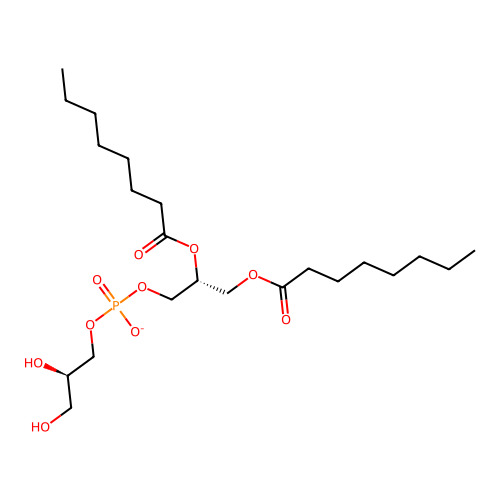

Comp Name: CD
Full Name: CADMIUM ION.
6NZI
Low resolution crystal structure of the bacterial multidrug efflux transporter AcrB in the presence of cadmium


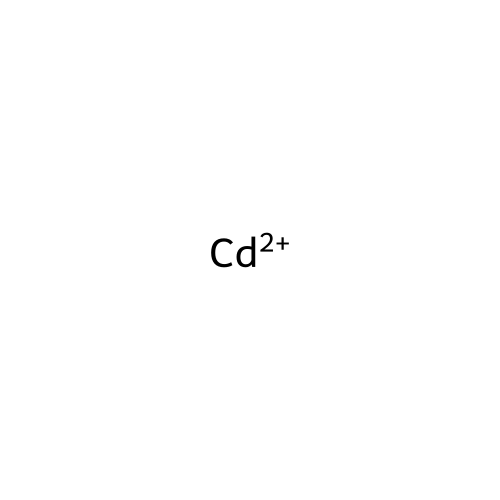

Comp Name: CPF
Full Name: 1-CYCLOPROPYL-6-FLUORO-4-OXO-7-PIPERAZIN-1-YL-1,4-DIHYDROQUINOLINE-3-CARBOXYLIC ACID.
8GJL
multi-drug efflux pump RE-CmeB bound with Ciprofloxacin


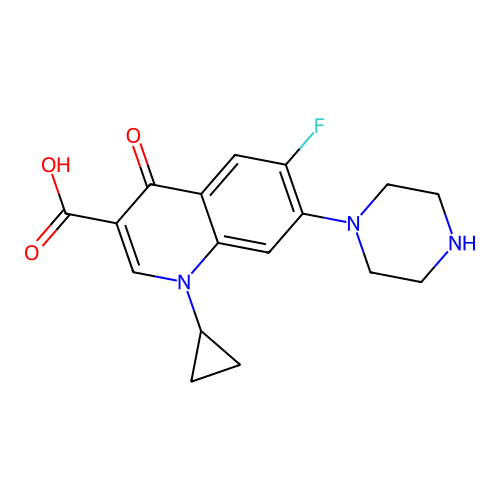

Comp Name: ZN
Full Name: ZINC ION.
4K0E
X-ray crystal structure of a heavy metal efflux pump, crystal form II
4K0J
X-ray crystal structure of a heavy metal efflux pump, crystal form I


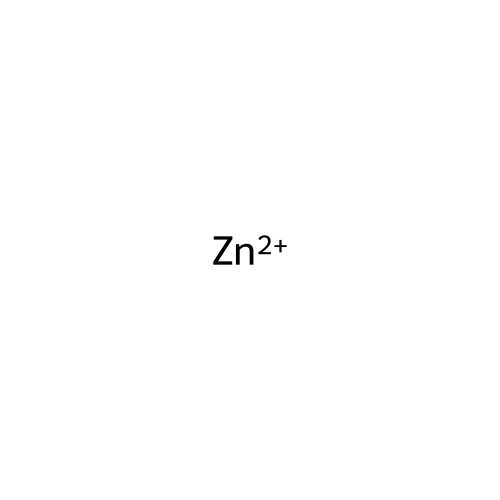

Comp Name: PTY
Full Name: PHOSPHATIDYLETHANOLAMINE.
6OWS
Cryo-EM structure of an Acinetobacter baumannii multidrug efflux pump
7KGD
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-I
7KGE
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-II
7KGG
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-I
7KGH
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-II
7KGI
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-III
8DEV
Cryo-electron microscopy structure of Neisseria gonorrhoeae multidrug efflux pump MtrD with colistin complex
6VKS
Cryo-electron microscopy structures of a gonococcal multidrug efflux pump illuminate a mechanism of drug recognition with ampicillin
8DEU
Cryo-electron microscopy structure of Neisseria gonorrhoeae multidrug efflux pump MtrD with CASP peptide complex
6VKT
Cryo-electron microscopy structures of a gonococcal multidrug efflux pump illuminate a mechanism of erythromycin drug recognition
6CSX
Singl

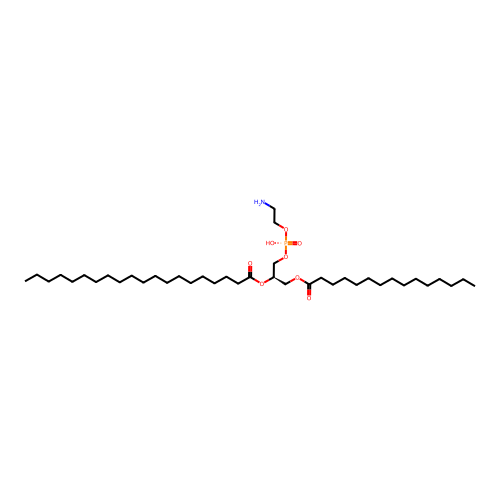

Comp Name: XE9
Full Name: [3-(3-chloranyl-2-piperazin-1-yl-quinolin-6-yl)phenyl]methanamine.
8QZT
Single particle cryo-EM co-structure of E. coli AcrB with bound BDM91531 inhibitor at 3.52 A resolution
8QZQ
Single particle cryo-EM co-structure of E. coli AcrB with bound BDM91531 inhibitor


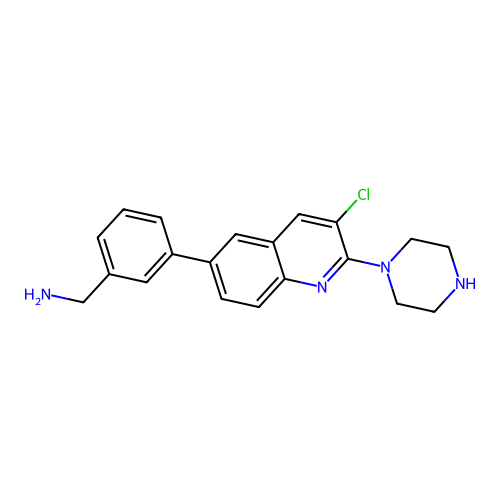

Comp Name: ET
Full Name: ETHIDIUM.
7KGG
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-I
7KGH
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-II
7KGI
Cryo-EM Structures of AdeB from Acinetobacter baumannii: AdeB-ET-III


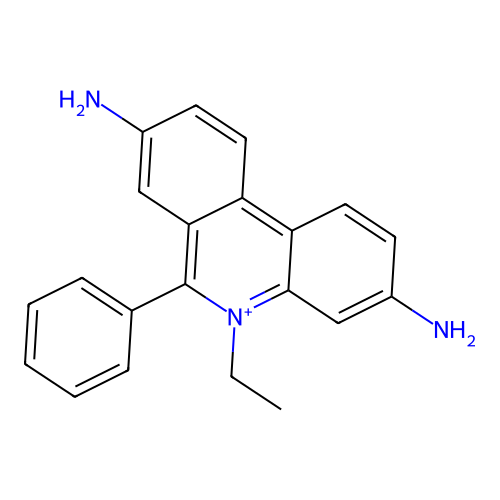

Comp Name: 3PE
Full Name: 1,2-Distearoyl-sn-glycerophosphoethanolamine.
7M4Q
Multidrug Efflux pump AdeJ
7M4P
Multidrug Efflux pump AdeJ with Eravacycline bound
9BFN
Cryo-EM co-structure of AcrB with the CU232 efflux pump inhibitor
9BFT
Cryo-EM co-structure of AcrB with CU244


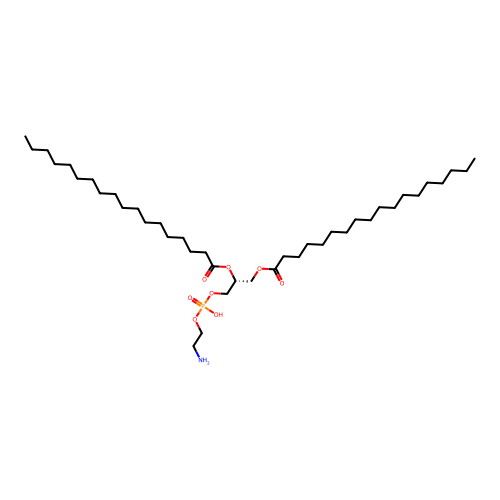

Comp Name: 80P
Full Name: (4S,4aS,5aR,12aS)-4-(diethylamino)-3,10,12,12a-tetrahydroxy-1,11-dioxo-8-[(2S)-pyrrolidin-2-yl]-7-(trifluoromethyl)-1,4,4a,5,5a,6,11,12a-octahydrotetracene-2-carboxamide.
7RY3
Multidrug Efflux pump AdeJ with TP-6076 bound


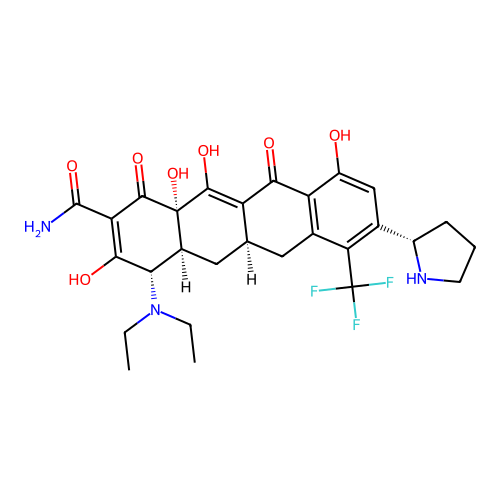

Comp Name: AIX
Full Name: (2R,4S)-2-[(1R)-1-{[(2R)-2-amino-2-phenylacetyl]amino}-2-oxoethyl]-5,5-dimethyl-1,3-thiazolidine-4-carboxylic acid.
6VKS
Cryo-electron microscopy structures of a gonococcal multidrug efflux pump illuminate a mechanism of drug recognition with ampicillin


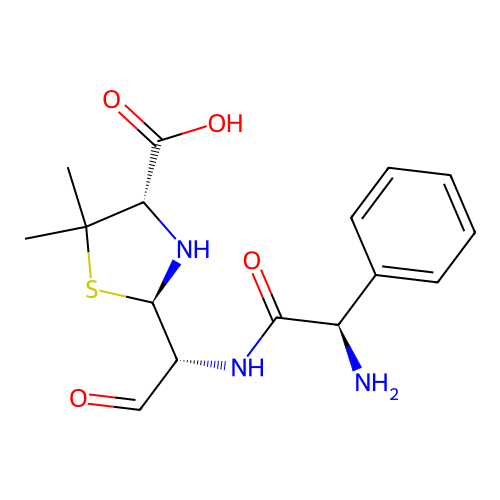

Comp Name: YQM
Full Name: Eravacycline.
7M4P
Multidrug Efflux pump AdeJ with Eravacycline bound


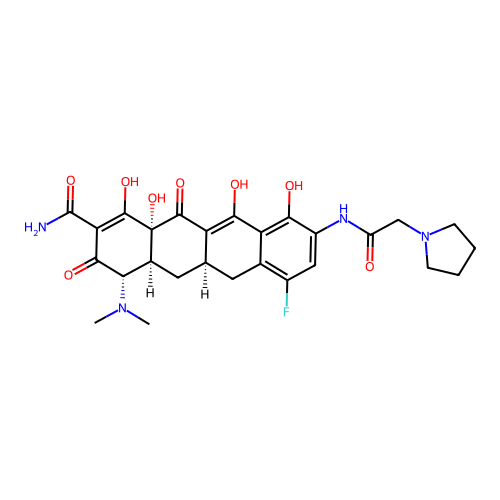

Comp Name: NI
Full Name: NICKEL (II) ION.
3D9B
Symmetric structure of E. coli AcrB
4C48
Crystal structure of AcrB-AcrZ complex


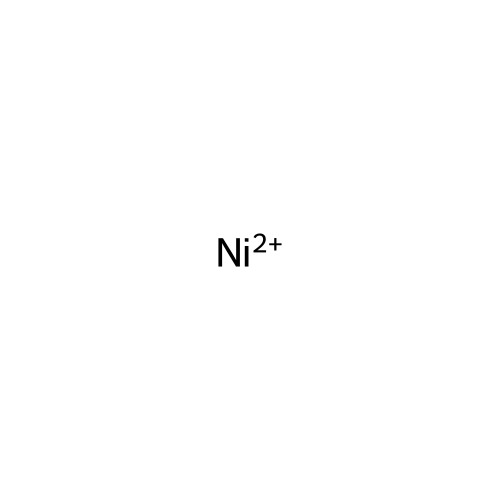

Comp Name: A1AN8
Full Name: (2S)-1-[(3R)-3-aminopyrrolidin-1-yl]-3-(3,4-dichlorophenoxy)propan-2-ol.
9BFH
Cryo-EM co-structure of AcrB with the CU032 efflux pump inhibitor


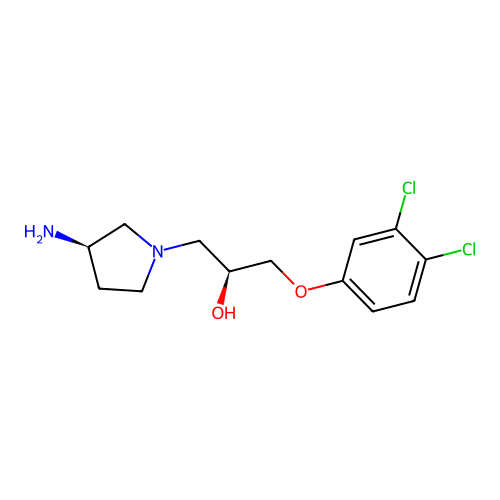

Comp Name: A1AON
Full Name: (2S)-1-(3,4-dichlorophenoxy)-3-(4-{[4-(trifluoromethyl)pyrimidin-2-yl]amino}piperidin-1-yl)propan-2-ol.
9BFM
Cryo-EM co-structure of AcrB with the EPM35 efflux pump inhibitor


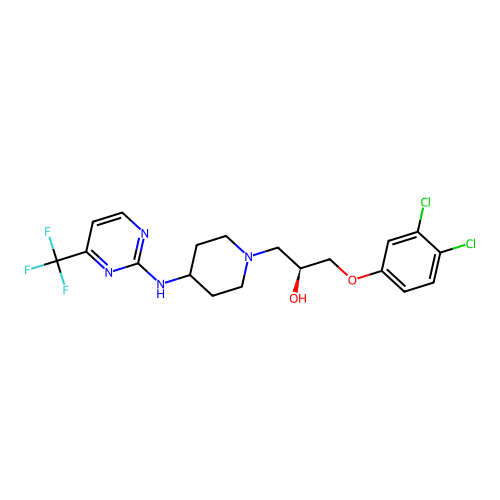

Comp Name: A1AOE
Full Name: (2R)-1-(4-aminopiperidin-1-yl)-3-[3-(trifluoromethyl)phenoxy]propan-2-ol.
9BFN
Cryo-EM co-structure of AcrB with the CU232 efflux pump inhibitor


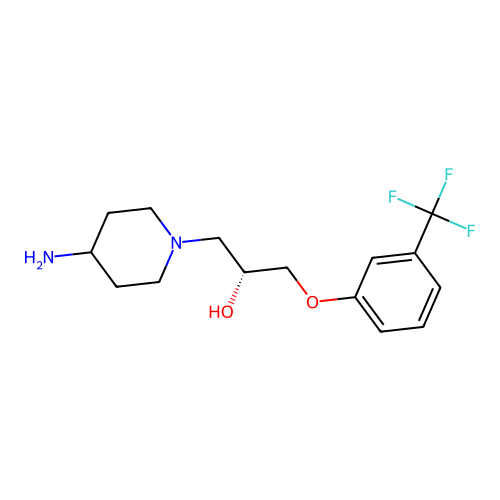

Comp Name: A1AOF
Full Name: (2S)-1-{[(1R,5R)-3-azabicyclo[3.1.0]hexan-6-yl]amino}-3-(3,5-dichlorophenoxy)propan-2-ol.
9BFT
Cryo-EM co-structure of AcrB with CU244


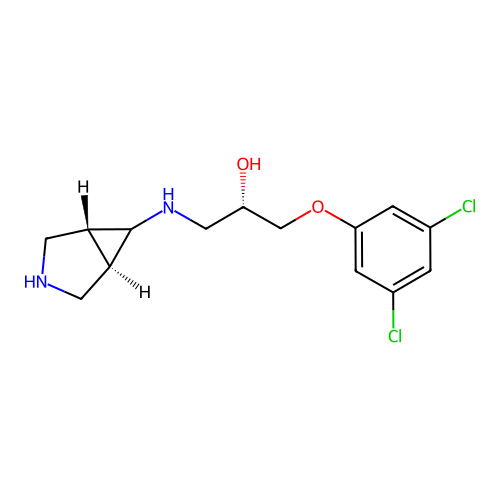

Comp Name: LLL
Full Name: (2R,3R,4R,5R)-2-((1S,2S,3R,4S,6R)-4,6-DIAMINO-3-((2R,3R,6S)-3-AMINO-6-(AMINOMETHYL)-TETRAHYDRO-2H-PYRAN-2-YLOXY)-2-HYDR
OXYCYCLOHEXYLOXY)-5-METHYL-4-(METHYLAMINO)-TETRAHYDRO-2H-PYRAN-3,5-DIOL.
8F4R
Gentamicin bound aminoglycoside efflux pump AcrD


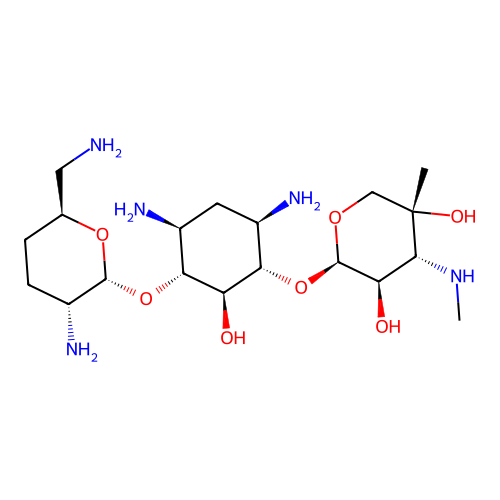

Comp Name: D12
Full Name: DODECANE.
6CSX
Single particles Cryo-EM structure of AcrB D407A associated with lipid bilayer at 3.0 Angstrom
7RR6
Multidrug efflux pump subunit AcrB
7RR7
Multidrug efflux pump subunit AcrB
7RR8
Multidrug efflux pump subunit AcrB
6BAJ
Cryo-EM structure of lipid bilayer in the native cell membrane nanoparticles of AcrB
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of 

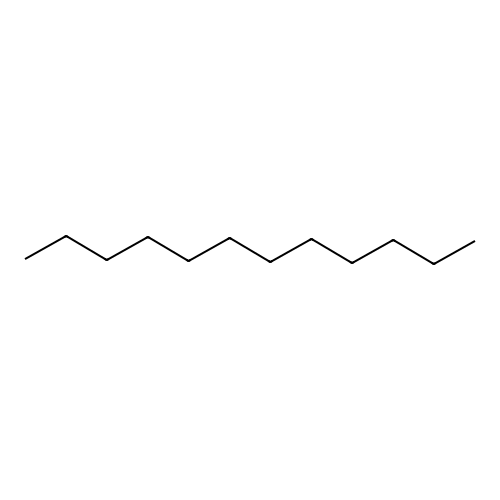

Comp Name: AV0
Full Name: Lauryl Maltose Neopentyl Glycol.
6IIA
MexB in complex with LMNG


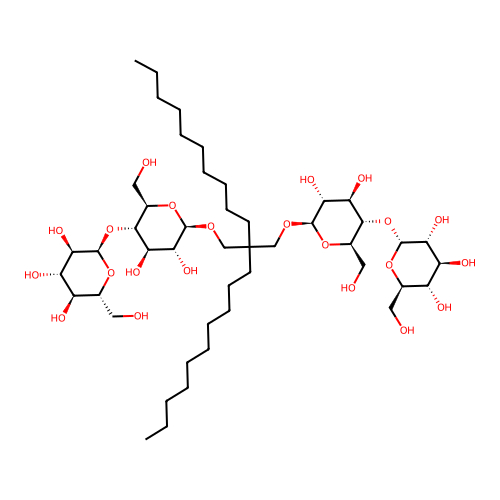

Comp Name: D10
Full Name: DECANE.
6ZOE
AcrB-F563A symmetric T protomer
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
6ZOG
Minocycline binding to 

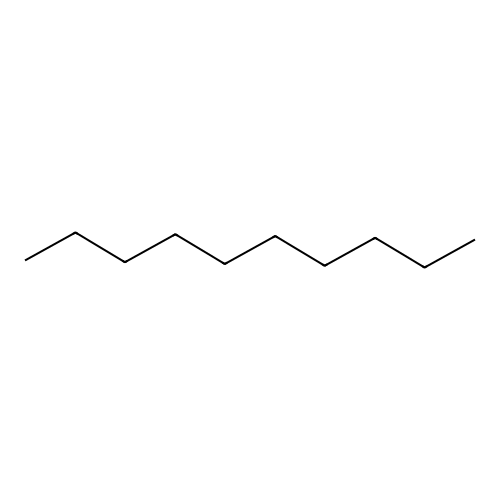

Comp Name: EDO
Full Name: 1,2-ETHANEDIOL.
6ZOE
AcrB-F563A symmetric T protomer
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
6ZO5
Fusidic acid binding to the TM1/TM2 groove of Acr

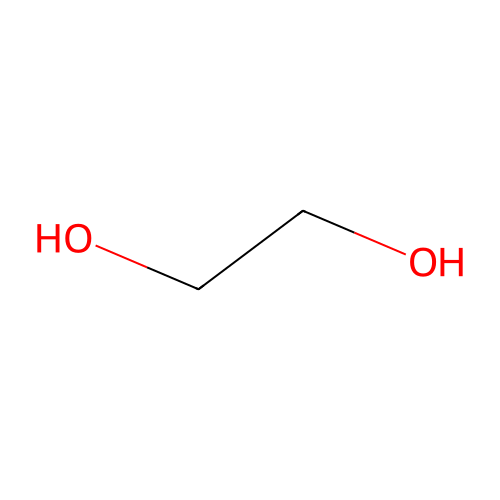

Comp Name: PGE
Full Name: TRIETHYLENE GLYCOL.
6ZOE
AcrB-F563A symmetric T protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


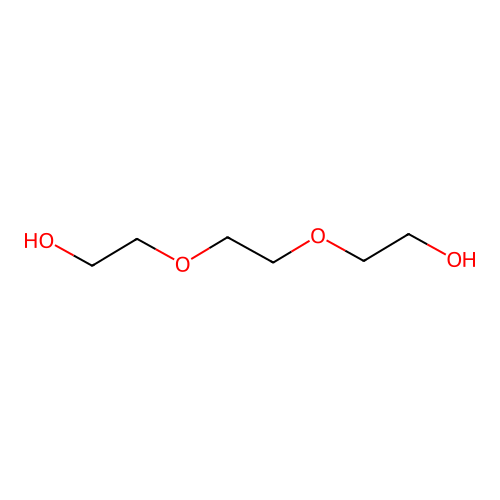

Comp Name: 5QG
Full Name: 3,3-dimethyl-8-morpholin-4-yl-6-(2-phenylethylsulfanyl)-1,4-dihydropyrano[3,4-c]pyridine-5-carbonitrile.
5ENO
MBX2319 bound structure of bacterial efflux pump.


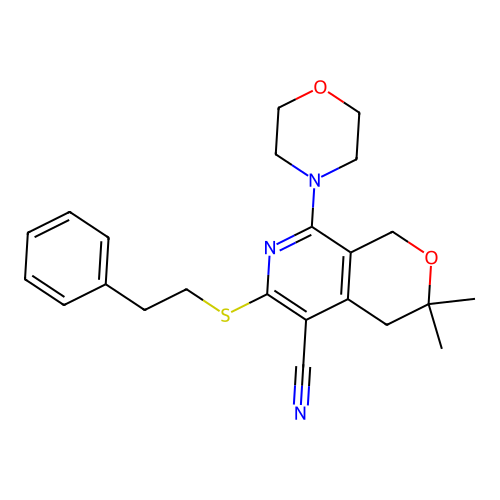

Comp Name: 5QF
Full Name: 6-[2-(3,4-dimethoxyphenyl)ethylsulfanyl]-8-[4-(2-methoxyethyl)piperazin-1-yl]-3,3-dimethyl-1,4-dihydropyrano[3,4-c]pyridine-5-carbonitrile.
5ENP
MBX2931 bound structure of bacterial efflux pump.
5NG5
multi-drug efflux; membrane transport; RND superfamily; Drug resistance


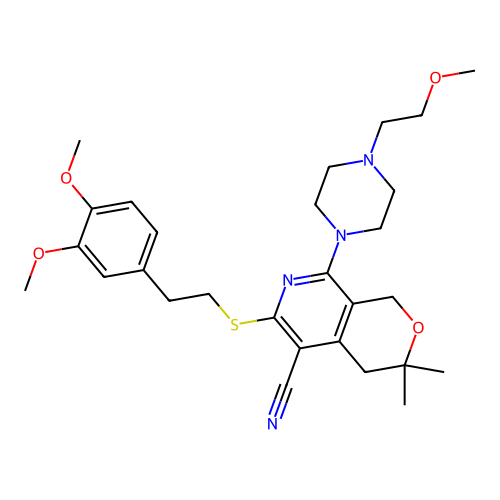

Comp Name: 5QE
Full Name: ~{N}-[4-[2-[[5-cyano-8-[(2~{S},6~{R})-2,6-dimethylmorpholin-4-yl]-3,3-dimethyl-1,4-dihydropyrano[3,4-c]pyridin-6-yl]sulfanyl]ethyl]phenyl]ethanamide.
5ENQ
MBX3132 bound structure of bacterial efflux pump.


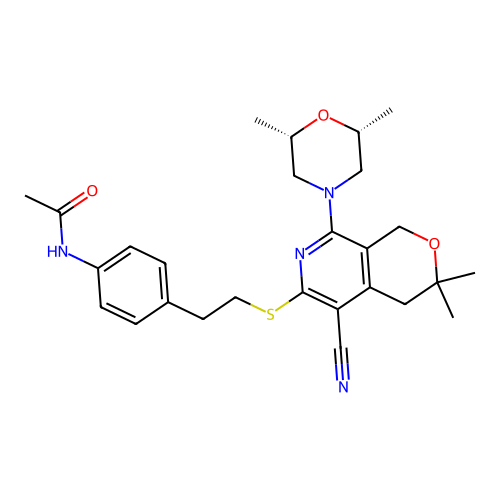

Comp Name: MBX
Full Name: ~{N}-[4-[2-[[5-cyano-8-[(2~{S},6~{S})-2,6-dimethylmorpholin-4-yl]-3,3-dimethyl-1,4-dihydropyrano[3,4-c]pyridin-6-yl]sulfanyl]ethyl]phenyl]prop-2-enamide.
5ENR
MBX3135 bound structure of bacterial efflux pump.


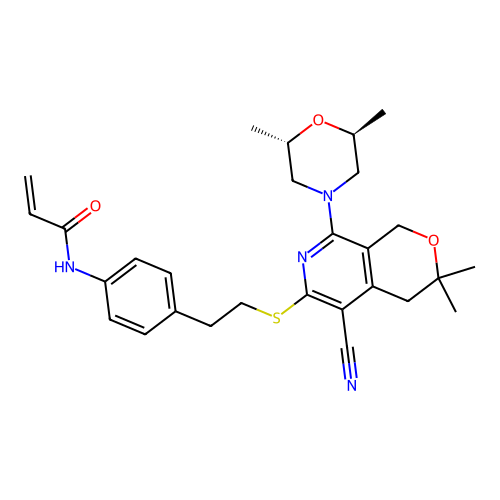

Comp Name: RHQ
Full Name: RHODAMINE 6G.
5ENS
Rhodamine bound structure of bacterial efflux pump.


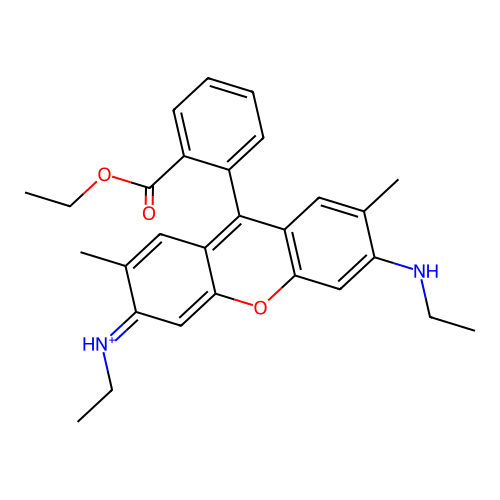

Comp Name: LMU
Full Name: DODECYL-ALPHA-D-MALTOSIDE.
6VEJ
TriABC transporter from Pseudomonas aeruginosa
2J8S
Drug Export Pathway of Multidrug Exporter AcrB Revealed by DARPin Inhibitors
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
4DX7
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P


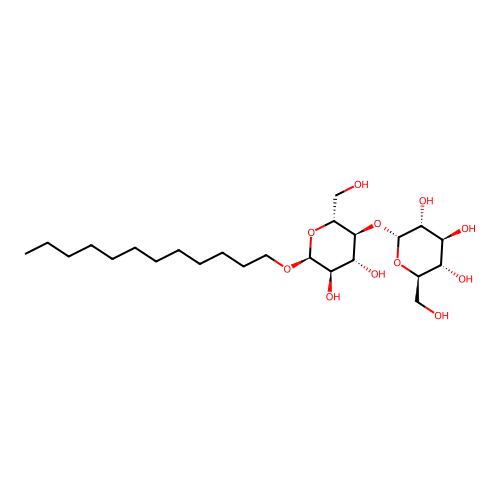

Comp Name: E2V
Full Name: (2R)-2-(hexadecanoyloxy)propyl nonadecanoate.
6VEJ
TriABC transporter from Pseudomonas aeruginosa


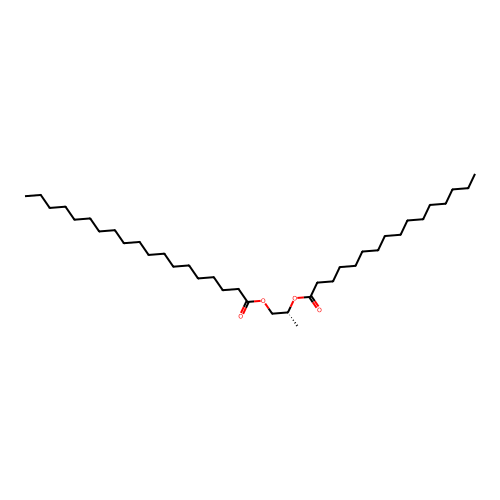

Comp Name: PLM
Full Name: PALMITIC ACID.
6VEJ
TriABC transporter from Pseudomonas aeruginosa


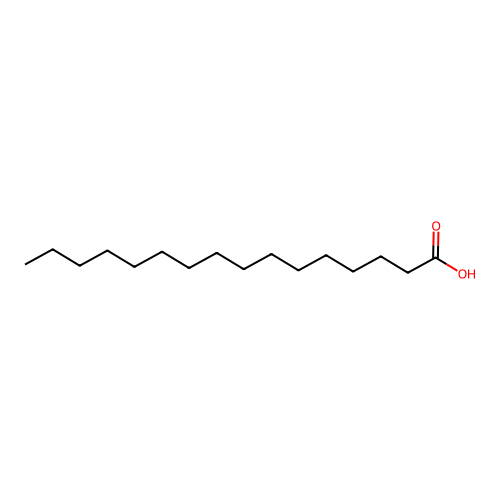

Comp Name: PEG
Full Name: DI(HYDROXYETHYL)ETHER.
7B8R
Doxycycline bound structure of bacterial efflux pump.
5ENT
Minocycline bound structure of bacterial efflux pump.


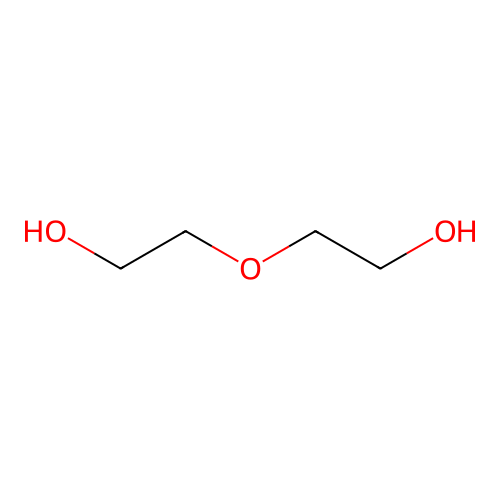

Comp Name: DXT
Full Name: (4S,4AR,5S,5AR,6R,12AS)-4-(DIMETHYLAMINO)-3,5,10,12,12A-PENTAHYDROXY-6-METHYL-1,11-DIOXO-1,4,4A,5,5A,6,11,12A-OCTAHYDROTETRACENE-2-CARBOXAMIDE.
7B8R
Doxycycline bound structure of bacterial efflux pump.


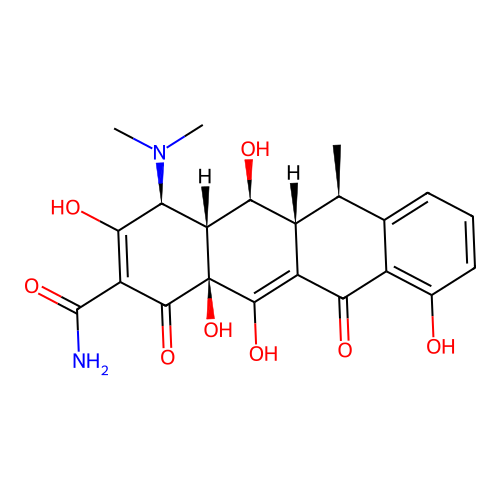

Comp Name: FUA
Full Name: FUSIDIC ACID.
7B8S
Fusidic acid bound structure of bacterial efflux pump.
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
5JMN
Fusidic acid bound AcrB
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P


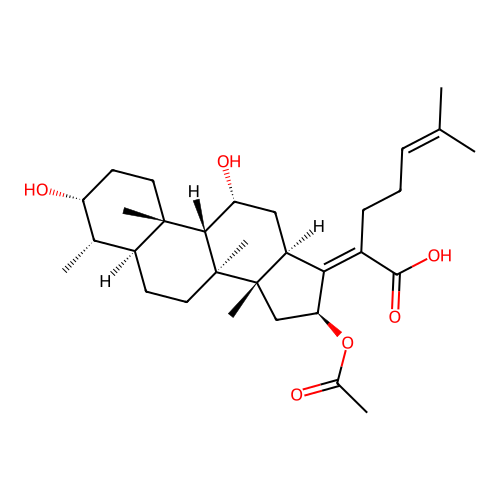

Comp Name: GOL
Full Name: GLYCEROL.
7CZ9
Crystal structure of multidrug efflux transporter OqxB from Klebsiella pneumoniae
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane

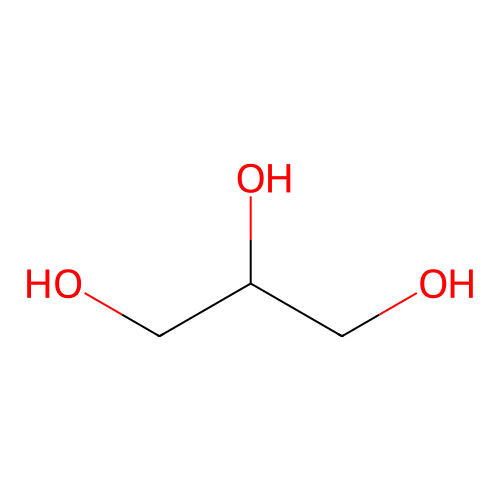

Comp Name: MIY
Full Name: (4S,4AS,5AR,12AS)-4,7-BIS(DIMETHYLAMINO)-3,10,12,12A-TETRAHYDROXY-1,11-DIOXO-1,4,4A,5,5A,6,11,12A-OCTAHYDROTETRACENE-2-
CARBOXAMIDE.
2DRD
Crystal structure of a multidrug transporter reveal a functionally rotating mechanism
5ENT
Minocycline bound structure of bacterial efflux pump.
3AOD
Structures of the multidrug exporter AcrB reveal a proximal multisite drug-binding pocket
4U8V
Coupling of remote alternating-access transport mechanisms for protons and substrates in the multidrug efflux pump AcrB
4U8Y
Coupling of remote alternating-access transport mechanisms for protons and substrates in the multidrug efflux pump AcrB
4U95
Coupling of remote alternating-access transport mechanisms for protons and substrates in the multidrug efflux pump AcrB
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
6ZO8
Minocy

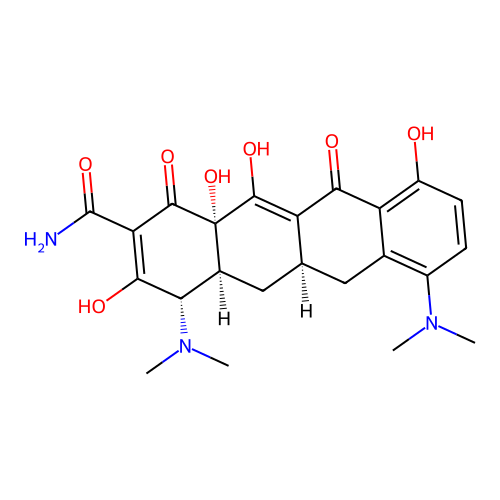

Comp Name: AIC
Full Name: (2S,5R,6R)-6-{[(2R)-2-AMINO-2-PHENYLETHANOYL]AMINO}-3,3-DIMETHYL-7-OXO-4-THIA-1-AZABICYCLO[3.2.0]HEPTANE-2-CARBOXYLIC
ACID.
2RDD
X-ray crystal structure of AcrB in complex with a novel transmembrane helix.


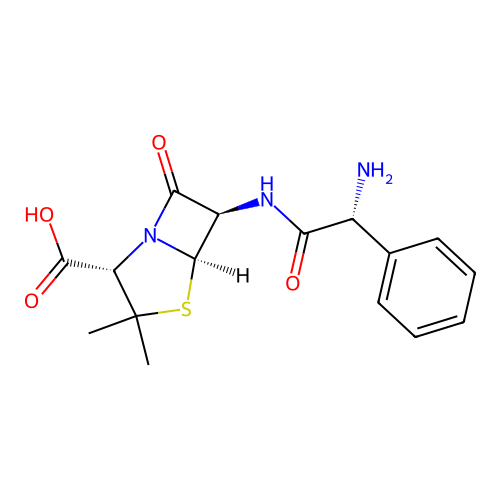

Comp Name: P9D
Full Name: [{2-[({[(3R)-1-{8-[(4-tert-butyl-1,3-thiazol-2-yl)carbamoyl]-4-oxo-3-[(E)-2-(1H-tetrazol-5-yl)ethenyl]-4H-pyrido[1,2-a]pyrimidin-2-yl}piperidin-3-yl]oxy}carbonyl)amino]ethyl}(dimethyl)ammonio]acetate.
3W9H
Structural basis for the inhibition of bacterial multidrug exporters
3W9J
Structural basis for the inhibition of bacterial multidrug exporters


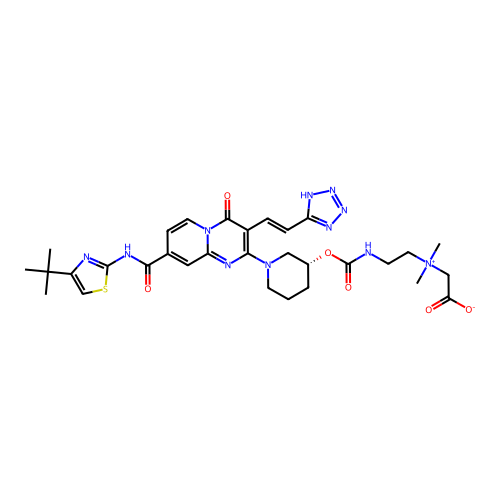

Comp Name: LFX
Full Name: (3S)-9-fluoro-3-methyl-10-(4-methylpiperazin-1-yl)-7-oxo-2,3-dihydro-7H-[1,4]oxazino[2,3,4-ij]quinoline-6-carboxylic acid.
7B8T
Levofloxacin bound structure of bacterial efflux pump.


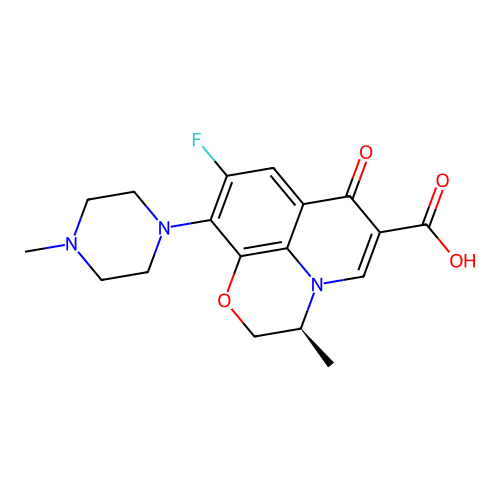

Comp Name: DM2
Full Name: DOXORUBICIN.
2DR6
Crystal structure of a multidrug transporter reveal a functionally rotating mechanism
4DX7
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop


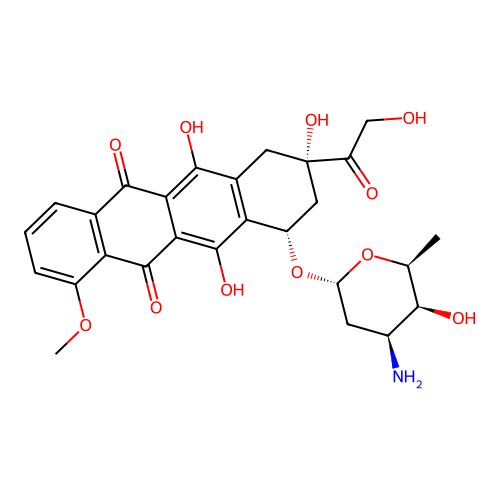

Comp Name: RFP
Full Name: RIFAMPICIN.
3AOB
Structures of the multidrug exporter AcrB reveal a proximal multisite drug-binding pocket
3AOD
Structures of the multidrug exporter AcrB reveal a proximal multisite drug-binding pocket


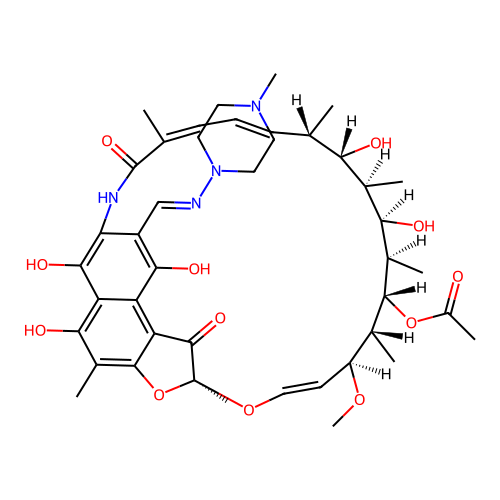

Comp Name: CU
Full Name: COPPER (II) ION.
4DNR
Crystal structure of the CusBA heavy-metal efflux complex from Escherichia coli, E716F mutant


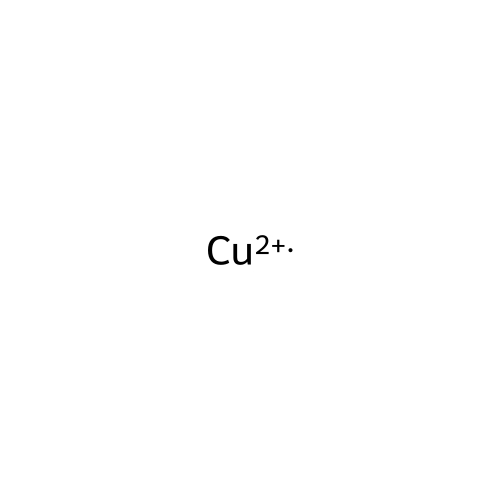

Comp Name: SO4
Full Name: SULFATE ION.
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
5JMN
Fusidic acid bound AcrB
6ZO5
Fusidic a

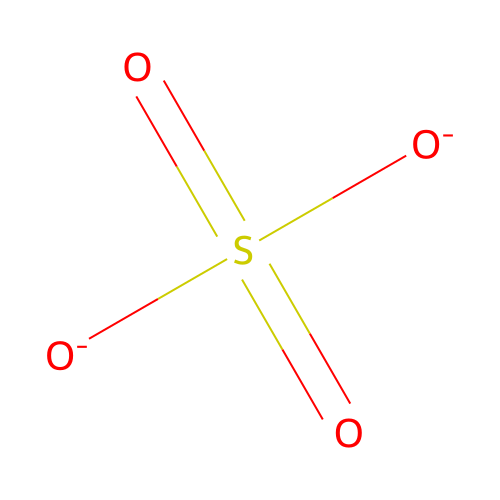

Comp Name: DDQ
Full Name: DECYLAMINE-N,N-DIMETHYL-N-OXIDE.
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L pro

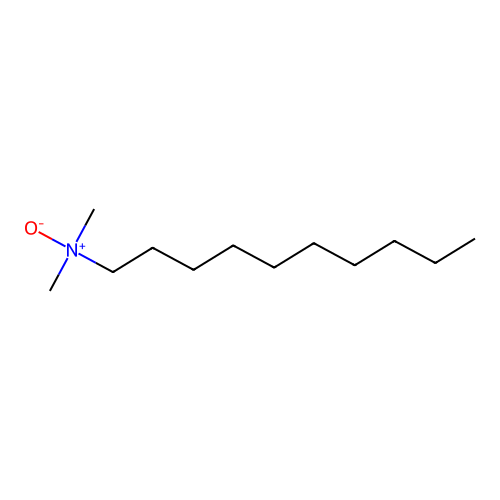

Comp Name: R16
Full Name: HEXADECANE.
6ZOF
Fusidic acid binding to the TM7/TM8 groove of AcrB-F380A T protomer
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


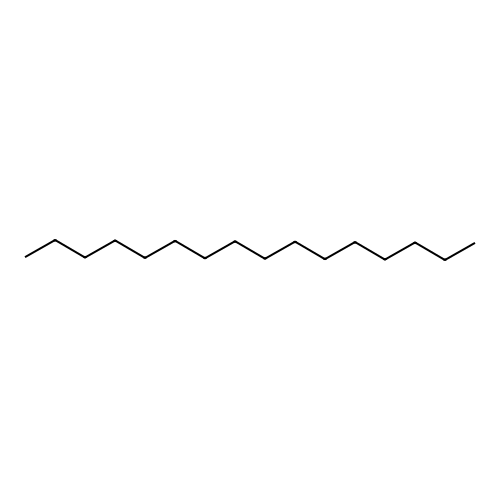

Comp Name: 3YI
Full Name: (2S,12Z,14E,16S,17S,18R,19R,20R,21S,22R,23S,24E)-8-formyl-5,6,9,17,19-pentahydroxy-23-methoxy-2,4,12,16,18,20,22-heptam
ethyl-1,11-dioxo-1,2-dihydro-2,7-(epoxypentadeca[1,11,13]trienoimino)naphtho[2,1-b]furan-21-yl acetate.
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV binding to the access pocket of AcrB-G616P T protomer


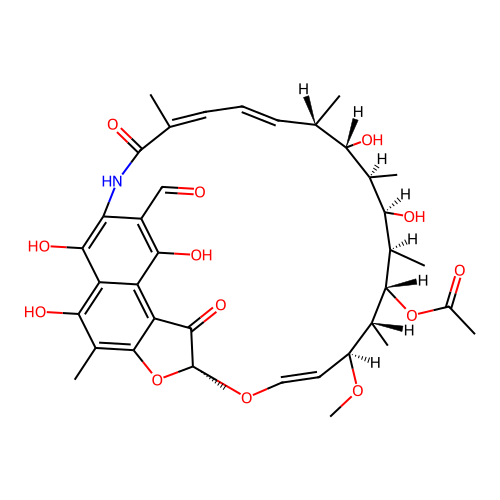

Comp Name: DDR
Full Name: (2S)-3-hydroxypropane-1,2-diyl didecanoate.
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


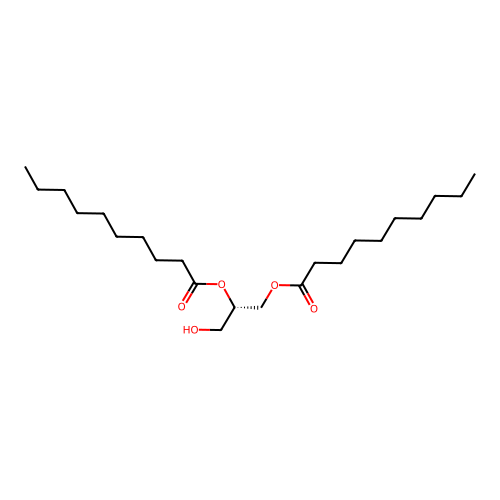

Comp Name: LPX
Full Name: (2S)-3-{[(R)-(2-aminoethoxy)(hydroxy)phosphoryl]oxy}-2-hydroxypropyl hexadecanoate.
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


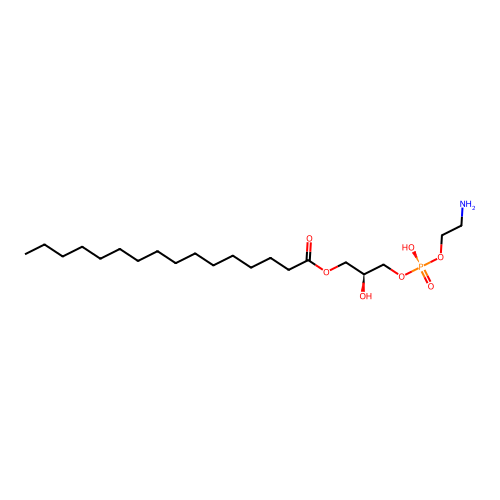

Comp Name: HEX
Full Name: HEXANE.
6ZOH
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P_G621P L and T protomers
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
4DX7
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loo

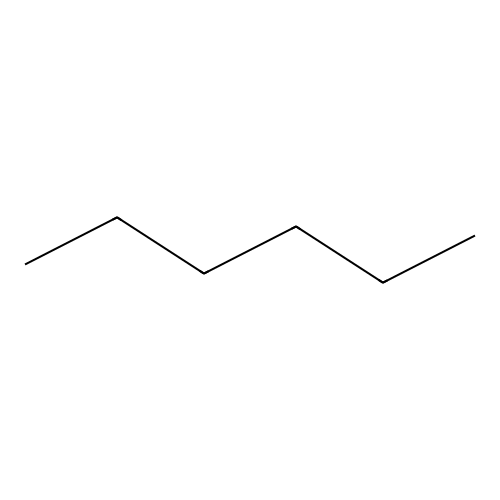

Comp Name: 1K8
Full Name: 3-chloranyl-2-piperazin-1-yl-quinoline.
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A


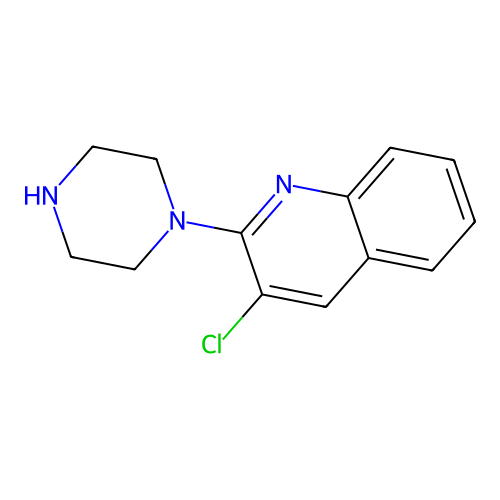

Comp Name: OCT
Full Name: N-OCTANE.
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4N
Fusidic acid bound AcrB_V340A
6Q4O
Fusidic acid bound AcrB_I27A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
5JMN
Fusidic acid bound AcrB
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV bin

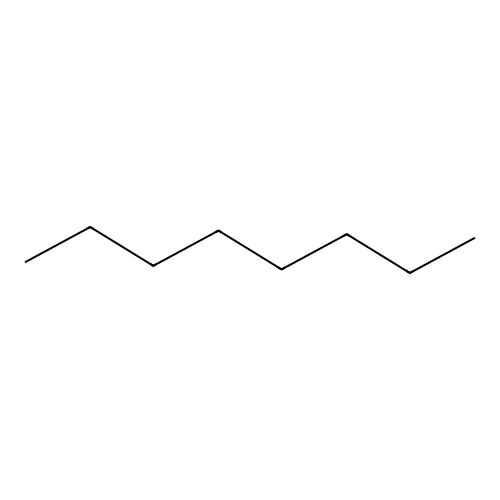

Comp Name: C14
Full Name: TETRADECANE.
7OUK
BDM88855 inhibitor bound to the transmembrane domain of AcrB
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A
7OUM
BDM88855 inhibitor bound to the transmembrane domain of AcrB-R971A
6Q4P
Fusidic acid bound AcrB_N298A
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZOC
Erythromycin binding to the access pocket of AcrB-G616P L protomer and 3-formylrifamycin SV binding to the access pocket of AcrB-G616P T protomer
6ZO6
Minocycline binding to the deep binding p

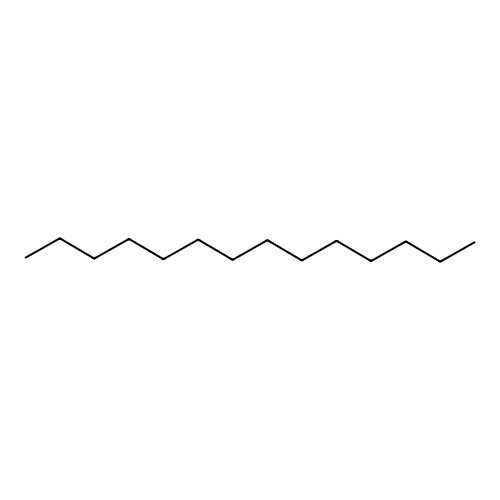

Comp Name: 1KE
Full Name: 1-(3-chloranyl-5-iodanyl-pyridin-2-yl)piperazine.
7OUL
BDM88832 inhibitor bound to the transmembrane domain of AcrB-R971A


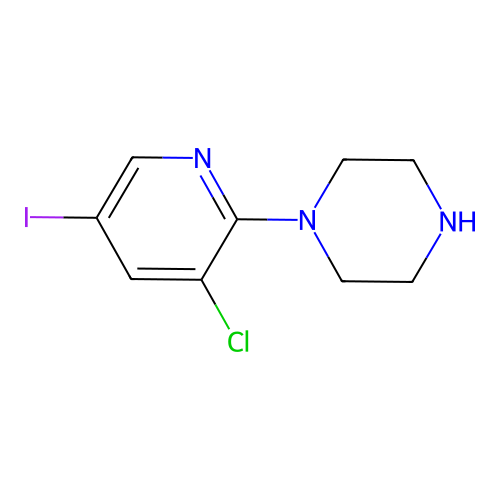

Comp Name: P6G
Full Name: HEXAETHYLENE GLYCOL.
6Q4N
Fusidic acid bound AcrB_V340A


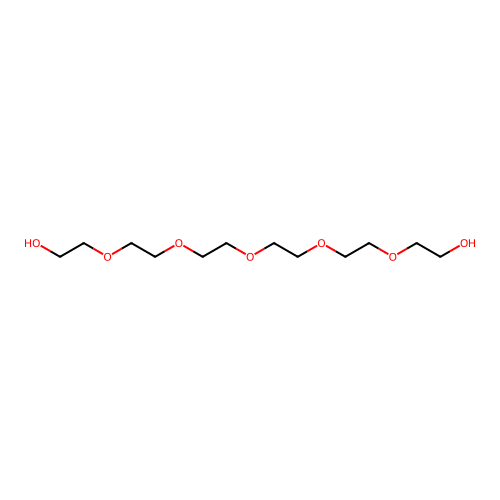

Comp Name: CL
Full Name: CHLORIDE ION.
6Q4P
Fusidic acid bound AcrB_N298A
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


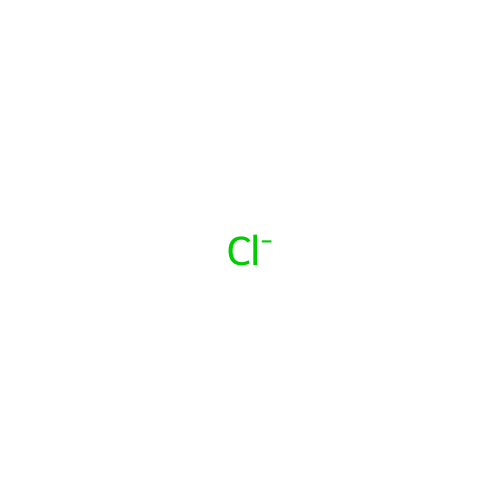

Comp Name: ETE
Full Name: 2-{2-[2-2-(METHOXY-ETHOXY)-ETHOXY]-ETHOXY}-ETHANOL.
6Q4P
Fusidic acid bound AcrB_N298A
6ZOB
3-Formylrifamycin SV binding to the access pocket of AcrB L protomer
5JMN
Fusidic acid bound AcrB


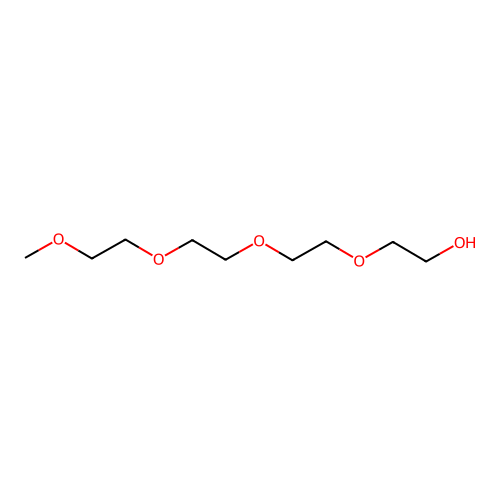

Comp Name: NA
Full Name: SODIUM ION.
6ZO7
3-Formylrifamycin SV binding to the access pocket of AcrB-G619P L and T protomer
6ZO8
Minocycline binding to the deep binding pocket of AcrB-G621P


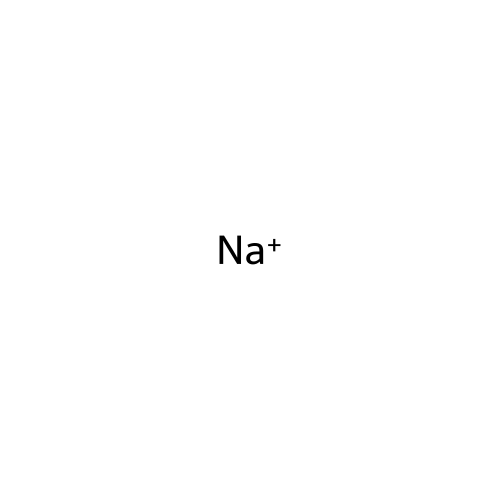

Comp Name: RBT
Full Name: RIFABUTIN.
6ZO9
Binding of two rifabutins to the access pocket of AcrB-G621P T protomer


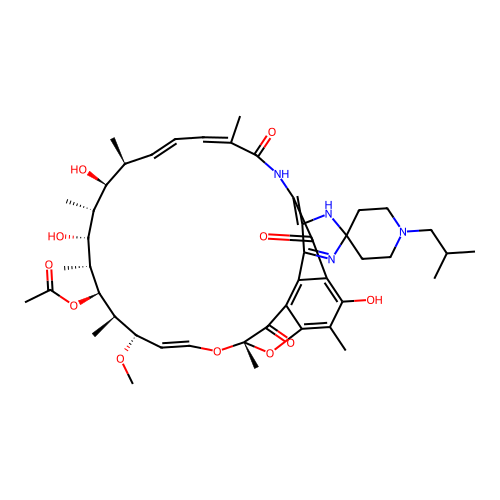

Comp Name: LNK
Full Name: PENTANE.
6ZOA
Partially induced AcrB T protomer and DDM binding to the TM8/PC2 pathway of AcrB L2 protomer


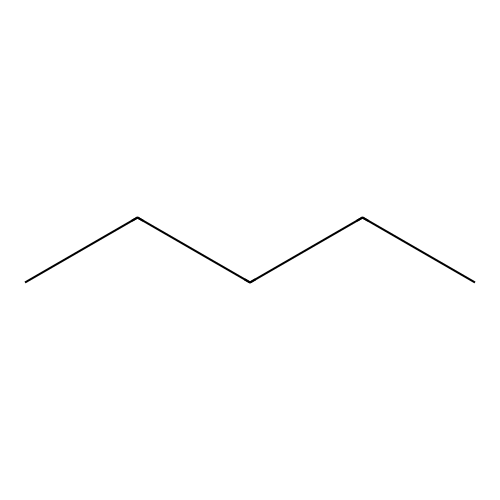

Comp Name: 8K6
Full Name: Octadecane.
6ZOD
Fusidic acid binding to the allosteric deep transmembrane domain binding pocket, TM7/TM8 groove, and TM1/TM2 groove of the fully induced AcrB T protomer
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


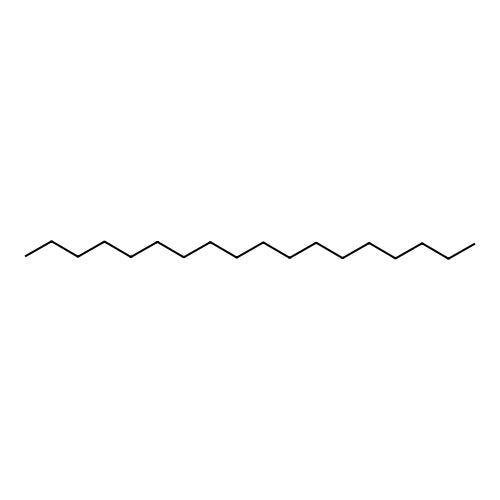

Comp Name: MYS
Full Name: PENTADECANE.
6ZOG
Minocycline binding to the deep binding pocket of AcrB-I38F_I671T
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


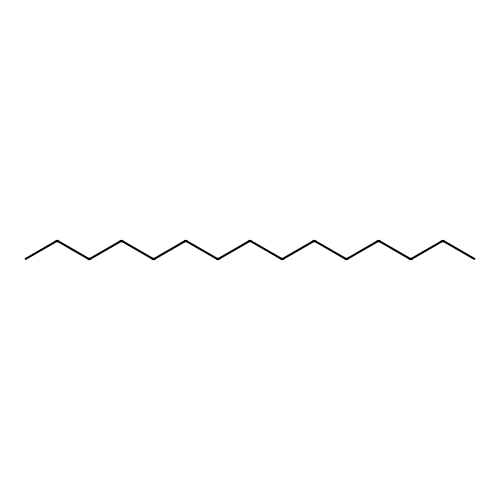

Comp Name: DD9
Full Name: nonane.
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop
5NC5
Crystal structure of AcrBZ in complex with antibiotic puromycin


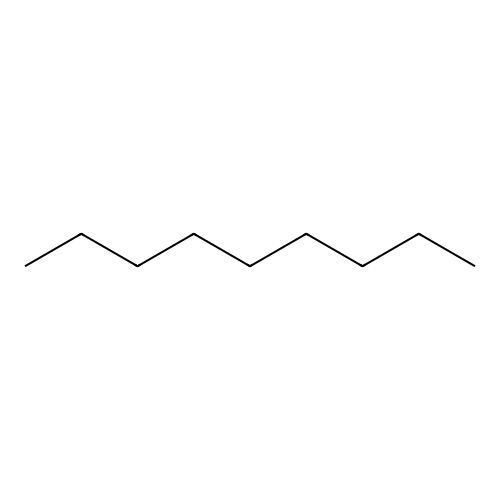

Comp Name: UND
Full Name: UNDECANE.
4DX5
Transport of drugs by the multidrug transporter AcrB involves an access and a deep binding pocket that are separated by a switch-loop


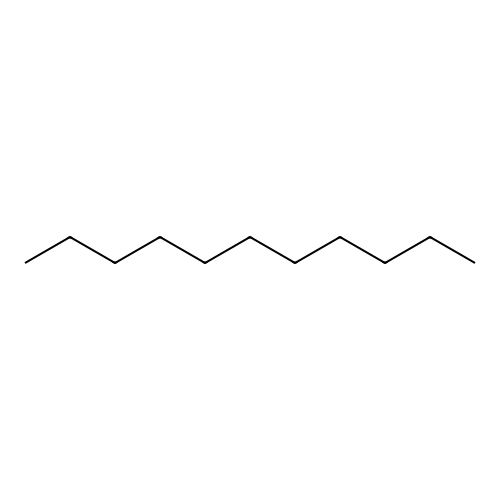

Comp Name: P3G
Full Name: 3,6,9,12,15-PENTAOXAHEPTADECANE.
5JMN
Fusidic acid bound AcrB


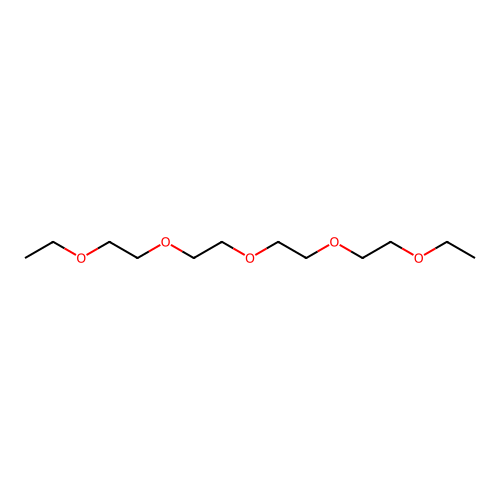

Comp Name: XPE
Full Name: 3,6,9,12,15,18,21,24,27-NONAOXANONACOSANE-1,29-DIOL.
6ZO5
Fusidic acid binding to the TM1/TM2 groove of AcrB-G619P_G621P


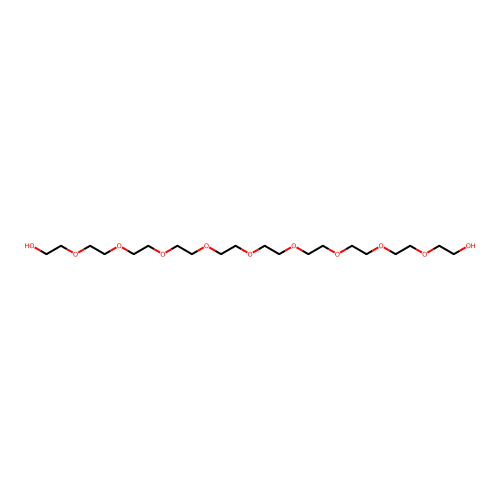

Comp Name: PUY
Full Name: PUROMYCIN.
5NC5
Crystal structure of AcrBZ in complex with antibiotic puromycin


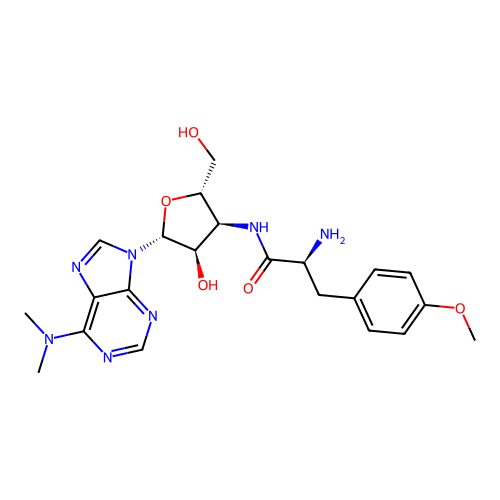

Comp Name: 1PE
Full Name: PENTAETHYLENE GLYCOL.
6ZO6
Minocycline binding to the deep binding pocket of AcrB-G619P


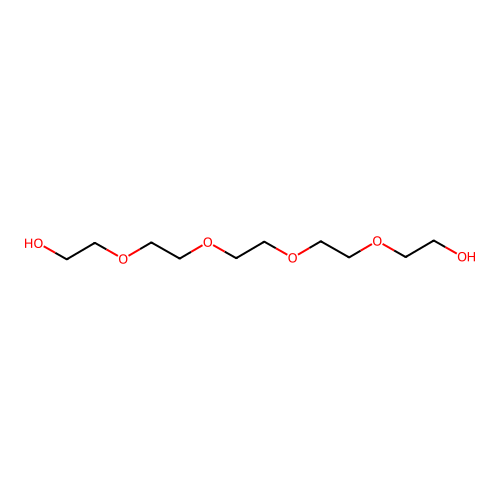

In [9]:
for entity, data in entity_dict.items():
    print(f'Comp Name: {entity}\nFull Name: {data["name"]}.')
    for i in range(len(data["entry"])):
        print(f'{data["entry"][i]}\n{data["title"][i]}')
    molecule = Chem.MolFromSmiles(data["smiles"])
    structure = Draw.MolToImage(molecule, size=(500,500))
    structure.show()